<a href="https://colab.research.google.com/github/lupis30puc/yelp_bert_random_forest/blob/update-6/Yelp_evaluation_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
!pip install transformers

     |████████████████████████████████| 1.8MB 7.7MB/s 
     |████████████████████████████████| 890kB 35.6MB/s 
     |████████████████████████████████| 2.9MB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=e773bf42a8bcdb36b5f540defbf95a277910e21458abd3e4d0455c5c8ee28d48
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## GPU

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Loading the tensors dataset and model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import time
import pickle

In [6]:
with open('/content/drive/MyDrive/Yelp/tensors_yelp/test_ids_128.pkl', 'rb') as f:
    test_ids = pickle.load(f)

with open('/content/drive/MyDrive/Yelp/tensors_yelp/train_ids_128.pkl', 'rb') as v:
    train_ids = pickle.load(v)

In [7]:
with open('/content/drive/MyDrive/Yelp/tensors_yelp/test_ids_99.pkl', 'rb') as f:
    test_ids_99 = pickle.load(f)

with open('/content/drive/MyDrive/Yelp/tensors_yelp/train_ids_99.pkl', 'rb') as v:
    train_ids_99 = pickle.load(v)

In [8]:
train_dataset = torch.load('/content/drive/MyDrive/Yelp/tensors_yelp/_train_128')
test_dataset = torch.load('/content/drive/MyDrive/Yelp/tensors_yelp/_test_128')

In [9]:
train_dataset_99 = torch.load('/content/drive/MyDrive/Yelp/tensors_yelp/_train_99')
test_dataset_99 = torch.load('/content/drive/MyDrive/Yelp/tensors_yelp/_test_99')

In [10]:
train_dataset[0]

(tensor([  101,  2117,  2190,  4770,  5869,  7136,  3477, 10797,  2154,  4392,
          2058, 18098,  6610,  2094,  8974,  4978,  8479,  7492,  2180,  2292,
          3288,  6544,  3835,  4638, 12679,  4569,  5541,  4268,  2926,  6001,
          2300,  7358, 21881, 12403, 19091,  2080,  3492,  5151,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [11]:
train_dataset_99[0]

(tensor([  101,  2117,  2190,  4770,  5869,  7136,  3477, 10797,  2154,  4392,
          2058, 18098,  6610,  2094,  8974,  4978,  8479,  7492,  2180,  2292,
          3288,  6544,  3835,  4638, 12679,  4569,  5541,  4268,  2926,  6001,
          2300,  7358, 21881, 12403, 19091,  2080,  3492,  5151,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# batch size
batch_size = 32

train_sampler = SequentialSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

train_sampler_99 = SequentialSampler(train_dataset_99)
train_dataloader_99 = DataLoader(train_dataset_99, sampler=train_sampler_99, batch_size=batch_size)

prediction_sampler_99 = SequentialSampler(test_dataset_99)
prediction_dataloader_99 = DataLoader(test_dataset_99, sampler=prediction_sampler_99, batch_size=batch_size)

### Initializing the models

In [13]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
device = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
"""
model = BertForSequenceClassification(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
"""
model = torch.load('/content/drive/MyDrive/Yelp/model_128/model-31-JAN_3e', map_location="cuda:0")  # Choose whatever GPU device number you want
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
device2 = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
"""
model = BertForSequenceClassification(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
"""
model2 = torch.load('/content/drive/MyDrive/Yelp/model_99/model-25-JAN_3e', map_location="cuda:0")  # Choose whatever GPU device number you want
model2.to(device2)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Evaluating the test set

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

    #np.argmax(logits, axis=1).flatten()

Evaluating the test dataset with the model of max_length 128:

In [16]:
%%time
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=b_input_mask, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  

#logits = logits[0].detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.
CPU times: user 9.65 s, sys: 7.41 s, total: 17.1 s
Wall time: 17.2 s


In [17]:
from torch.nn import functional as F
loss = F.cross_entropy(outputs.logits, b_labels)

In [18]:
loss

tensor(0.0062, device='cuda:0')

In [ ]:
loss.backward()

In [19]:
#test
total_eval_accuracy = 0
for i in range(len(predictions)):
  total_eval_accuracy += flat_accuracy(predictions[i], true_labels[i])
print(total_eval_accuracy)

75.15625


In [20]:
#test
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  Accuracy: 0.92


In [21]:
#test
pred_flat = np.argmax(predictions[0], axis=1).flatten()
labels_flat = true_labels[0].flatten()
tot_ev_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
print(tot_ev_acc)

0.84375


Evaluating the test dataset with the model of max_length 99:

In [22]:
%%time
# Put model in evaluation mode
model2.eval()

# Tracking variables 
predictions2 , true_labels2 = [], []

# Predict 
for batch in prediction_dataloader_99:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids_99, b_input_mask_99, b_labels_99 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs_99 = model2(b_input_ids_99, token_type_ids=None, 
                      attention_mask=b_input_mask_99)

  logits_99 = outputs_99[0]

  # Move logits and labels to CPU
  logits_99 = logits_99.detach().cpu().numpy()
  label_ids_99 = b_labels_99.to('cpu').numpy()
  

#logits = logits[0].detach().cpu().numpy()

  # Store predictions and true labels
  predictions2.append(logits_99)
  true_labels2.append(label_ids_99)

print('    DONE.')

    DONE.
CPU times: user 7.95 s, sys: 5.87 s, total: 13.8 s
Wall time: 13.8 s


In [23]:
from torch.nn import functional as F
loss_99 = F.cross_entropy(outputs_99.logits, b_labels_99)
loss_99

tensor(0.0040, device='cuda:0')

In [37]:
#test
total_eval_accuracy_99 = 0
for i in range(len(predictions2)):
  total_eval_accuracy_99 += flat_accuracy(predictions2[i], true_labels2[i])
print(total_eval_accuracy_99)

75.21875


In [38]:
#test
avg_val_accuracy_99 = total_eval_accuracy_99 / len(prediction_dataloader_99)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy_99))

  Accuracy: 0.92


In [39]:
#test
pred_flat2 = np.argmax(predictions2[0], axis=1).flatten()
labels_flat2 = true_labels2[0].flatten()
tot_ev_acc2 = np.sum(pred_flat2 == labels_flat2) / len(labels_flat2)
print(tot_ev_acc2)

0.84375


Evaluating the train dataset with the model of max_length 128:

In [24]:
%%time
# Tracking variables 
predictions_tr , true_labels_tr = [], []

# Predict 
for batch in train_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids_tr, b_input_mask_tr, b_labels_tr = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs_tr = model(b_input_ids_tr, token_type_ids=b_input_mask_tr, 
                      attention_mask=b_input_mask_tr)
      
  logits_tr = outputs_tr[0]

  # Move logits and labels to CPU
  logits_tr = logits_tr.detach().cpu().numpy()
  label_ids_tr = b_labels_tr.to('cpu').numpy()
  

#logits = logits[0].detach().cpu().numpy()

  # Store predictions and true labels
  predictions_tr.append(logits_tr)
  true_labels_tr.append(label_ids_tr)

print('    DONE.')

    DONE.
CPU times: user 39.9 s, sys: 30.2 s, total: 1min 10s
Wall time: 1min 10s


In [25]:
loss_tr = F.cross_entropy(outputs_tr.logits, b_labels_tr)
loss_tr

tensor(0.0444, device='cuda:0')

In [34]:
#train
total_eval_accuracy_tr = 0
for i in range(len(predictions_tr)):
  total_eval_accuracy_tr += flat_accuracy(predictions_tr[i], true_labels_tr[i])
print(total_eval_accuracy_tr)

318.52403846153845


In [35]:
#train
avg_val_accuracy_tr = total_eval_accuracy_tr / len(train_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy_tr))

  Accuracy: 0.98


In [36]:
#train
pred_flat_tr = np.argmax(predictions_tr[0], axis=1).flatten()
labels_flat_tr = true_labels_tr[0].flatten()
tot_ev_acc_tr = np.sum(pred_flat_tr == labels_flat_tr) / len(labels_flat_tr)
print(tot_ev_acc_tr)

1.0


Evaluating the train dataset with the model of max_length 99:

In [26]:
%%time
# Put model in evaluation mode
#model2.eval()

# Tracking variables 
predictions2_tr , true_labels2_tr = [], []

# Predict 
for batch in train_dataloader_99:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids_99_tr, b_input_mask_99_tr, b_labels_99_tr = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs_99_tr = model2(b_input_ids_99_tr, token_type_ids=None, 
                      attention_mask=b_input_mask_99_tr)

  logits_99_tr = outputs_99_tr[0]

  # Move logits and labels to CPU
  logits_99_tr = logits_99_tr.detach().cpu().numpy()
  label_ids_99_tr = b_labels_99_tr.to('cpu').numpy()
  

#logits = logits[0].detach().cpu().numpy()

  # Store predictions and true labels
  predictions2_tr.append(logits_99_tr)
  true_labels2_tr.append(label_ids_99_tr)

print('    DONE.')

    DONE.
CPU times: user 32.9 s, sys: 24.7 s, total: 57.5 s
Wall time: 57.5 s


In [27]:
loss_99_tr = F.cross_entropy(outputs_99_tr.logits, b_labels_99_tr)
loss_99_tr

tensor(0.0334, device='cuda:0')

In [40]:
#test
total_eval_accuracy_99_tr = 0
for i in range(len(predictions2_tr)):
  total_eval_accuracy_99_tr += flat_accuracy(predictions2_tr[i], true_labels2_tr[i])
print(total_eval_accuracy_99_tr)

320.375


In [41]:
#test
avg_val_accuracy_99_tr = total_eval_accuracy_99_tr / len(train_dataloader_99)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy_99_tr))

  Accuracy: 0.99


In [42]:
#test
pred_flat2_tr = np.argmax(predictions2_tr[0], axis=1).flatten()
labels_flat2_tr = true_labels2_tr[0].flatten()
tot_ev_acc2_tr = np.sum(pred_flat2_tr == labels_flat2_tr) / len(labels_flat2_tr)
print(tot_ev_acc2_tr)

1.0


## Comparison of loss

In [28]:
if loss < loss_99:
  if loss_tr < loss_99_tr:
    print('the model 128 is better')
  elif loss_tr > loss_99_tr:
    print('its a tie')
else:
  print('the model 99 is better')

the model 99 is better


In [29]:
print('the difference (for the test set) between model 128 and model 99 is: ' + str(loss-loss_99))

the difference (for the test set) between model 128 and model 99 is: tensor(0.0022, device='cuda:0')


In [30]:
print('the difference (for the train set) between model 128 and model 99 is: ' + str(loss_tr-loss_99_tr))

the difference (for the train set) between model 128 and model 99 is: tensor(0.0111, device='cuda:0')


In [31]:
print('Stats of batch_size = 32 | max_length = 128 | epochs= 3')
df3 = pd.read_pickle('/content/drive/MyDrive/Yelp/loss_accuracy_results_2df/stats_128_3e_32_')
#df3[['Training Loss', 'Valid. Loss', 'Valid. Accur.']].apply(lambda x: round(x, 2))
df3

Stats of batch_size = 32 | max_length = 128 | epochs= 3


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.308592,0.274082,0.883384,0:03:50,0:00:20
2,0.170174,0.244651,0.920351,0:03:50,0:00:20
3,0.103651,0.271682,0.917302,0:03:50,0:00:20


In [32]:
print('Stats of batch_size = 32 | max_length = 99 | epochs= 3')
df7 = pd.read_pickle('/content/drive/MyDrive/Yelp/loss_accuracy_results_2df/stats_99_3e_32')
#df7[['Training Loss', 'Valid. Loss', 'Valid. Accur.']].apply(lambda x: round(x, 2))
df7

Stats of batch_size = 32 | max_length = 99 | epochs= 3


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.294424,0.318371,0.878430,0:03:17,0:00:17
2,0.166630,0.231409,0.918826,0:03:20,0:00:17
3,0.100725,0.312035,0.913491,0:03:19,0:00:18


In [33]:
average_loss_3e =[[128, 32]+ list(df3[['Training Loss', 'Valid. Loss', 'Valid. Accur.']].mean()),
                  [99, 32] + list(df7[['Training Loss', 'Valid. Loss', 'Valid. Accur.']].mean())
                  ]
                  
print('Comparison of loss and accuracy for the 3 epochs run:')
loss_analysis_3e = pd.DataFrame(data=average_loss_3e, columns=['Max. Length', 'Batch Size', 'Training Loss', 'Valid. Loss', 'Valid. Accur.'])
loss_analysis_3e

Comparison of loss and accuracy for the 3 epochs run:


,Max. Length,Batch Size,Training Loss,Valid. Loss,Valid. Accur.
0,128,32,0.194139,0.263472,0.907012
1,99,32,0.187260,0.287272,0.903582


## Saving logits - pred labels.
for both train and test

In [44]:
predictions2[0]

array([[ 3.0506377, -2.4544013],
       [-2.1819134,  1.8736161],
       [-3.0999944,  2.6844313],
       [ 3.0060601, -2.3407938],
       [ 3.1808267, -2.873114 ],
       [-3.1453807,  2.7815762],
       [-3.184499 ,  2.7352898],
       [-2.7547746,  2.3747795],
       [ 3.2465417, -2.8321352],
       [ 3.3311489, -2.763662 ],
       [ 3.1069078, -2.7008655],
       [-3.3118598,  2.8378687],
       [ 2.933878 , -2.4781406],
       [-1.1789597,  1.0930814],
       [-3.177808 ,  2.686439 ],
       [-3.1957235,  2.7017624],
       [ 2.6598947, -2.0953972],
       [-3.0731606,  2.6333494],
       [ 2.3621705, -1.8306882],
       [-3.0769148,  2.5526905],
       [ 2.9885793, -2.500867 ],
       [-3.1877484,  2.7369823],
       [ 2.6635275, -2.1782904],
       [-3.1373687,  2.8639278],
       [ 2.7181003, -2.0343425],
       [-2.9361038,  2.3863578],
       [-1.355257 ,  1.2916147],
       [ 3.076884 , -2.6558518],
       [ 3.0625947, -2.7086399],
       [ 3.181285 , -2.6442196],
       [-3

In [55]:
# for the model 99
logits_test2 = [list(np.argmax(predictions2[p], axis=1).flatten()) for p in range(len(predictions2))]
print('length of the test predictions: ' + str(len(logits_test2)))
# converting the list of lists into a single list
bert_test_labels = [label for l in logits_test2 for label in l]
print('number of predicted labels: ' + str(len(bert_test_labels)))

length of the test predictions: 82
number of predicted labels: 2599


In [50]:
# for the model 128
logits_test = [list(np.argmax(predictions[p], axis=1).flatten()) for p in range(len(predictions))]
print(len(logits_test))
# converting the list of lists into a single list
bert_test_labels_128 = [label for l in logits_test for label in l]
print(len(bert_test_labels_128))

82
2599


In [54]:
# for the model 99
logits_train2 = [list(np.argmax(predictions2_tr[p], axis=1).flatten()) for p in range(len(predictions2_tr))]
print('length of the train predictions: ' + str(len(logits_train2)))
# converting the list of lists into a single list
bert_train_labels = [label for l in logits_train2 for label in l]
print('number of predicted labels: ' + str(len(bert_train_labels)))

length of the train predictions: 325
number of predicted labels: 10394


In [56]:
# for the model 128
logits_train = [list(np.argmax(predictions_tr[p], axis=1).flatten()) for p in range(len(predictions_tr))]
print(len(logits_train))
bert_train_labels_128 = [label for l in logits_train for label in l]
print(len(bert_train_labels_128))

325
10394


### Comparing the logits obtain during training to the ones obtain here:

In [60]:
logits_val_3e = torch.load('/content/drive/MyDrive/Yelp/model_128/logits_val_3e')
print(len(logits_val_3e))
logits_train_3e = torch.load( '/content/drive/MyDrive/Yelp/model_128/logits_train_3e')
print(len(logits_train_3e))

246
975


In [59]:
bert_test_labels[0:7]

[0, 1, 1, 0, 0, 1, 1]

In [66]:
len(logits_val_3e[0])

32

In [68]:
32*24

7840

In [71]:
labels_test_3e = logits_val_3e[164:]
labels_test_3e = np.concatenate(labels_test_3e, axis=0)
labels_test_3e[0:7]

array([0, 1, 1, 0, 0, 1, 1])

In [ ]:
flat_true_labels[20:33]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0])

In [72]:
bert_train_labels[0:7]

[1, 0, 0, 1, 1, 1, 0]

In [75]:
labels_train_3e = logits_train_3e[650:]
labels_train_3e = np.concatenate(labels_train_3e, axis=0)
labels_train_3e[0:7]

array([1, 0, 1, 0, 0, 1, 1])

In [76]:
flat_true_labels_tr = np.concatenate(true_labels_tr, axis=0)
flat_true_labels_tr[0:7]

array([1, 0, 0, 1, 1, 1, 0])

The things above are to check if the train predictions obtain here are the same as the 3rd epoch. 

Spoiler: no they are not the same

In [69]:
torch.save(bert_train_labels, '/content/drive/MyDrive/Yelp/model_99/flat_pred_labels_train')
torch.save(bert_test_labels, '/content/drive/MyDrive/Yelp/model_99/flat_pred_labels_test')

torch.save(bert_train_labels_128, '/content/drive/MyDrive/Yelp/model_128/flat_pred_labels_train')
torch.save(bert_test_labels_128, '/content/drive/MyDrive/Yelp/model_128/flat_pred_labels_test')

## Matthews Corr Coef

In [77]:
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


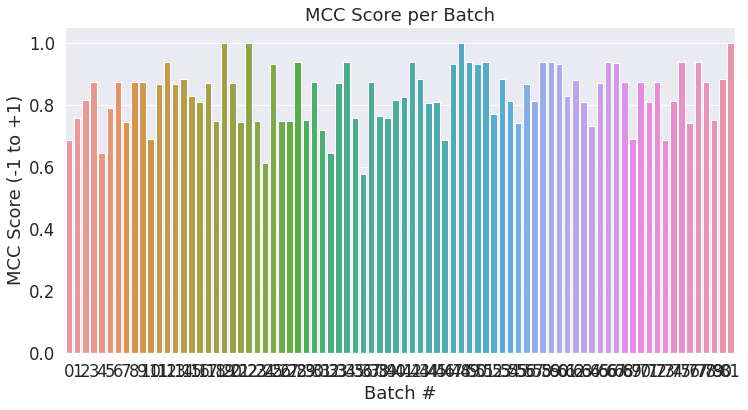

In [78]:
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
# change the x axis labels so its readable

plt.show()

In [79]:
# Combine the results across all batches. 
#flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
#flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_predictions = bert_test_labels.copy()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.833


# Trying with new sentences/ reviews

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Yelp/model_99/')

In [ ]:
review_example = 'Very friendly and helpful staff. Increasing my Dutch vocabulary during commute thanks to a great suggestion.'

positive_review ='A truly inspiring venue. Friendly, helpful staff. Amazing portraits and awesome surroundings.  Hope to go back sometime soon'
#'Great set up. Very good food. Luxury Bar surroundings. Good food but quite pricey. Staff are polite & very helpful. They all look smart.'


#'Terrible customer service downstairs within the kitchen appliances department.'
negative_review = 'Completely appalled by the lack of assistance or help I received in trying to resolve an issue with an TV that has now been going on for a month. Staff appeared disinterested and unhelpful, despite me explaining I have spent in excess of five hours on hold trying to speak to someone about the resolution of the issue. There is no clarity of who to speak to, no one seems to know what is going on, and no one knows what the resolution is. I appreciate these are challenging times but I and have had no communication in any form from the company, I am the one who appears to doing all the leg work, even having to speak to the repair contractors in person to find out what is happening! Terrible service, terrible aftercare, terrible communication - would seriously advise against making any large electrical purchases from the company.'

## the real test
Remember only 2 labels: 0=negative, 1=positive

In [ ]:
def encode(sequence):
  """
  The copied version was:
    return tokenizer.encode_plus(
                sequence,
                add_special_tokens=True,
                max_length= 150,
                return_token_type_ids=False,
                padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt',
                truncation = True
    )
  """ 
  return tokenizer.encode_plus(sequence, return_token_type_ids=False, return_tensors = 'pt')

In [ ]:
def predict(sequence='I love you a lot. You are really great. You are wonderful and awesome.'):
    encoded = encode(sequence)
    encoded_ids = encoded['input_ids'].to(device)
    enconded_attention = encoded['attention_mask'].to(device)
    with torch.no_grad():
        output = model(encoded_ids, attention_mask=enconded_attention)[0]
        output = output.detach().cpu().numpy()
        pred_flat = np.argmax(output, axis=1).flatten()
        #sig_factor = torch.sigmoid(output) / torch.sigmoid(output).sum()
        #return {'proportional':  sig_factor.numpy().tolist(), 'sigmoid': torch.sigmoid(output).numpy().tolist(), 'stars': pred_flat.item() + 1, 'raw': output.numpy().tolist()}
        return {'label': pred_flat.item()}

In [ ]:
predict(review_example)

{'label': 1}

# Converting input ids back to words:

In [ ]:
test_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_test_2599.pkl')
test_df.reset_index(drop=True, inplace=True)
test_df.shape

(2599, 3)

In [ ]:
test_df.text[2]

'walked uncle saturday help cpap machine met respiratory therapist gentleman named juan helpful explained uncle needed use machine knowledgeable uncle condition able answer questions showed machine works clean patient came choosing mask polite friendly thanks juan experience pleasant'

In [ ]:
test_ids[2]

[101,
 2939,
 4470,
 5095,
 2393,
 18133,
 9331,
 3698,
 2777,
 16464,
 19294,
 10170,
 2315,
 5348,
 14044,
 4541,
 4470,
 2734,
 2224,
 3698,
 3716,
 3085,
 4470,
 4650,
 2583,
 3437,
 3980,
 3662,
 3698,
 2573,
 4550,
 5776,
 2234,
 10549,
 7308,
 13205,
 5379,
 4283,
 5348,
 3325,
 8242,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
list(tokenizer.vocab.keys())[2939]

'walked'

In [ ]:
tokenizer.decode(test_dataset[2][0])

'[CLS] walked uncle saturday help cpap machine met respiratory therapist gentleman named juan helpful explained uncle needed use machine knowledgeable uncle condition able answer questions showed machine works clean patient came choosing mask polite friendly thanks juan experience pleasant [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'